<table width="100%">
  <tr>
    <td>
      <h1 style="text-align: left; font-size:300%;">Homework 2 - Time Series forecasting challenge</h1>
      <table align="left">
        <tr>
          <td style="text-align: left;">Bottazzi Daniele</td>
          <td style="text-align: left;">10666960</td>
          <td style="text-align: left;"><a href="mailto:nouhaila.benhdidou@mail.polimi.it">daniele.bottazzi@mail.polimi.it</a></td>
        </tr>
        <tr>
          <td style="text-align: left;">Resta Sara</td>
          <td style="text-align: left;">10667600</td>
          <td style="text-align: left;"><a href="mailto:daniele.bottazzi@mail.polimi.it">sara.resta@mail.polimi.it</a></td>
        </tr>
        <tr>
          <td style="text-align: left;">Saldarini Gaia</td>
          <td style="text-align: left;">10684442</td>
          <td style="text-align: left;"><a href="mailto:annalisa.imperiali@mail.polimi.it">gaia.saldarini@mail.polimi.it</a></td>
        </tr>
      </table>
    </td>
    <td width="20%">
      <div style="text-align: right">
          <br>
        <b style="font-size: 120%;">AN2DL course</b><br>
        <b>a.y. 2023-2024</b>
          <br><br>
        prof. M. Matteucci<br>
        prof. G. Boracchi<br>
      </div>
    </td>
  </tr>
</table>

# Filtering based on DTW distance matrix

### Import libraries

In [3]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [4]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [5]:
# Import other libraries
!pip install fastdtw
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from fastdtw import fastdtw  # You may need to install the fastdtw library
import operator
from itertools import chain

Defaulting to user installation because normal site-packages is not writeable


### Load and preprocess the dataset

In [16]:
data = np.load('dtw_distances.npy', mmap_mode='r')

In [17]:
# Assuming data is a symmetric matrix
num_rows, num_cols = data.shape
print(data.shape)

(47974, 47974)


In [ ]:
# Initialize variables for summary statistics and indices
total_sum = 0

min_value = float('inf')
max_value = float('-inf')

less_075_count = 0
less_05_count  = 0
less_025_count = 0
less_02_count  = 0
less_015_count = 0
less_01_count  = 0

less_075_indices = []
less_05_indices  = []
less_025_indices = []
less_02_indices  = []
less_015_indices = []
less_01_indices  = []

chunk_size = 1000

for i in range(0, num_rows, chunk_size):
    print(i // chunk_size + 1, "of", len(range(0, num_rows, chunk_size)))
    for j in range(0, num_cols): 
        # Process the chunk as needed
        chunk = data[i:i+chunk_size, j]

        # Compute summary statistics for the chunk
        chunk_sum = np.sum(chunk)
        total_sum += chunk_sum
        min_value = min(min_value, np.min(chunk))
        max_value = max(max_value, np.max(chunk))

        # Count values and save indices
        less_075_indices_chunk = np.where(chunk < 0.75)
        less_05_indices_chunk  = np.where(chunk < 0.5)
        less_025_indices_chunk = np.where(chunk < 0.25)
        less_02_indices_chunk  = np.where(chunk < 0.2)
        less_015_indices_chunk = np.where(chunk < 0.15)
        less_01_indices_chunk  = np.where(chunk < 0.1)

        less_075_count += len(less_075_indices_chunk[0])
        less_05_count  += len(less_05_indices_chunk[0])
        less_025_count += len(less_025_indices_chunk[0])
        less_02_count  += len(less_02_indices_chunk[0])
        less_015_count += len(less_015_indices_chunk[0])
        less_01_count  += len(less_01_indices_chunk[0])

        less_075_indices.extend(zip(less_075_indices_chunk[0] + i, [j] * len(less_075_indices_chunk[0])))
        less_05_indices.extend(zip(less_05_indices_chunk[0] + i, [j] * len(less_05_indices_chunk[0])))
        less_025_indices.extend(zip(less_025_indices_chunk[0] + i, [j] * len(less_025_indices_chunk[0])))
        less_02_indices.extend(zip(less_02_indices_chunk[0] + i, [j] * len(less_02_indices_chunk[0])))
        less_015_indices.extend(zip(less_015_indices_chunk[0] + i, [j] * len(less_015_indices_chunk[0])))
        less_01_indices.extend(zip(less_01_indices_chunk[0] + i, [j] * len(less_01_indices_chunk[0])))

In [19]:
# Compute final summary statistics
average_value = total_sum / (num_rows * num_cols)

# Print the computed values
print("\nMinimum Value:", min_value)
print("Maximum Value:", max_value)
print("Average Value:", average_value)

# Print the count of values and indices
print("\nCount of values < 0.75:", less_075_count)
print("Count of values < 0.5: ", less_05_count)
print("Count of values < 0.25:", less_025_count)
print("Count of values < 0.2: ", less_02_count)
print("Count of values < 0.15:", less_015_count)
print("Count of values < 0.1: ", less_01_count)


Minimum Value: 0.0
Maximum Value: 99.8320463320463
Average Value: 27.415255204732578

Count of values < 0.75: 75746
Count of values < 0.5:  55446
Count of values < 0.25: 50374
Count of values < 0.2:  49970
Count of values < 0.15: 49580
Count of values < 0.1:  49218


In [20]:
less_01_indices[0:5]

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]

In [21]:
# Given an array of tuples less_01_indices = [(i1, j1), (i2, j2), ...]
# Filter out tuples where i is equal to j
less_075_indices_non_self = [(i, j) for i, j in less_075_indices if i != j]
less_05_indices_non_self  = [(i, j) for i, j in less_05_indices if i != j]
less_025_indices_non_self = [(i, j) for i, j in less_025_indices if i != j]
less_02_indices_non_self  = [(i, j) for i, j in less_02_indices if i != j]
less_015_indices_non_self = [(i, j) for i, j in less_015_indices if i != j]
less_01_indices_non_self  = [(i, j) for i, j in less_01_indices if i != j]

# Now less_01_indices contains tuples excluding (i, i) pairs
less_01_indices_non_self[0:5]

[(116, 50), (109, 108), (108, 109), (50, 116), (280, 198)]

In [22]:
print(len(less_075_indices_non_self))
print(len(less_05_indices_non_self))
print(len(less_025_indices_non_self))
print(len(less_02_indices_non_self))
print(len(less_015_indices_non_self))
print(len(less_01_indices_non_self))

27772
7472
2400
1996
1606
1244


In [23]:
# Keep only one pair for each symmetrical pair
less_075_indices_unique = list(set(tuple(sorted(pair)) for pair in less_075_indices_non_self))
less_05_indices_unique  = list(set(tuple(sorted(pair)) for pair in less_05_indices_non_self))
less_025_indices_unique = list(set(tuple(sorted(pair)) for pair in less_025_indices_non_self))
less_02_indices_unique = list(set(tuple(sorted(pair)) for pair in less_02_indices_non_self))
less_015_indices_unique = list(set(tuple(sorted(pair)) for pair in less_015_indices_non_self))
less_01_indices_unique  = list(set(tuple(sorted(pair)) for pair in less_01_indices_non_self))

# Now unique_pairs contains unique pairs while maintaining symmetry
less_01_indices_unique[0:5]

[(41601, 41602),
 (31907, 32652),
 (23283, 23287),
 (41162, 41164),
 (40601, 40602)]

In [24]:
print(len(less_075_indices_unique))
print(len(less_05_indices_unique))
print(len(less_025_indices_unique))
print(len(less_02_indices_unique))
print(len(less_015_indices_unique))
print(len(less_01_indices_unique))

13886
3736
1200
998
803
622


In [25]:
np.save("less_075_indices_unique.npy", less_075_indices_unique)
np.save("less_05_indices_unique.npy", less_05_indices_unique)
np.save("less_025_indices_unique.npy", less_025_indices_unique)
np.save("less_02_indices_unique.npy", less_02_indices_unique)
np.save("less_015_indices_unique.npy", less_015_indices_unique)
np.save("less_01_indices_unique.npy", less_01_indices_unique)

In [30]:
between_075_05_indices_unique = set(less_075_indices_unique).difference(less_05_indices_unique)
between_075_05_indices_unique_flatten = list(chain.from_iterable(between_075_05_indices_unique))

less_01_indices_unique_flatten = list(chain.from_iterable(less_01_indices_unique))

print(len(between_075_05_indices_unique))
print(len(between_075_05_indices_unique_flatten))
print(len(set(between_075_05_indices_unique_flatten)))
print()
print(len(set(less_01_indices_unique_flatten)))

10150
20300
3500

1132


In [27]:
display_num = 10

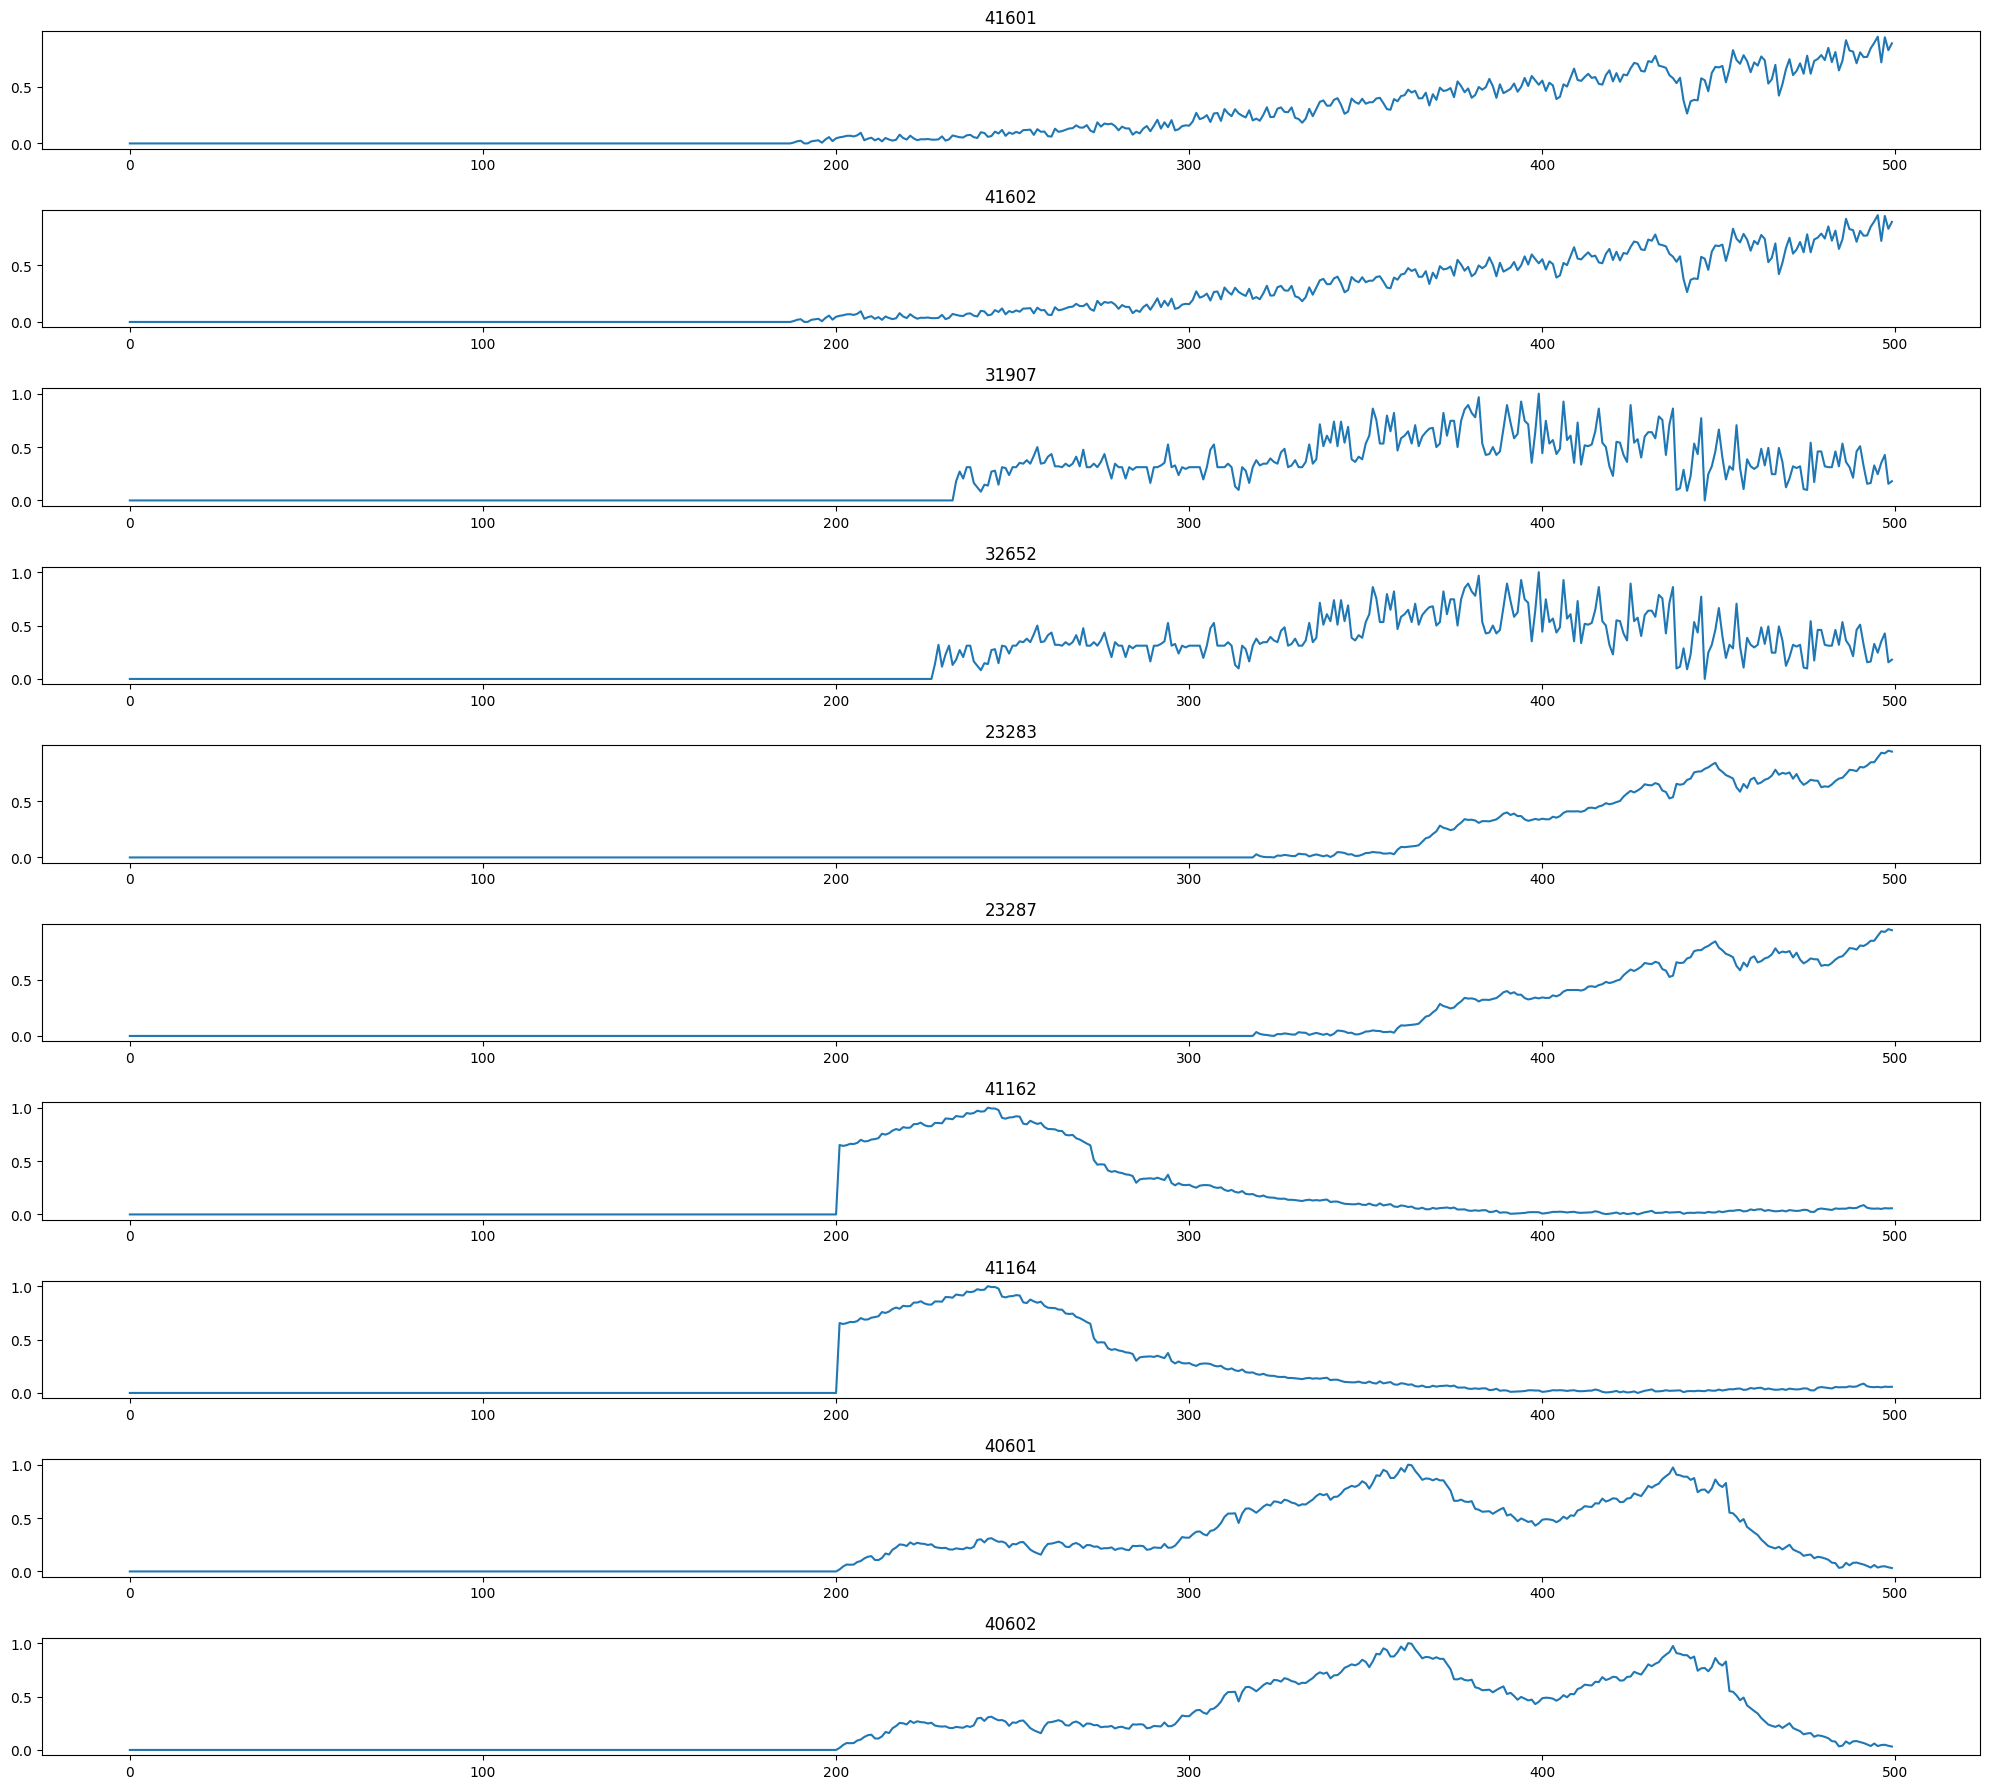

In [31]:
idx = less_01_indices_unique_flatten
display_series(unique_series[idx[:display_num], :], categories=idx[:display_num], num_series=display_num, last=500)

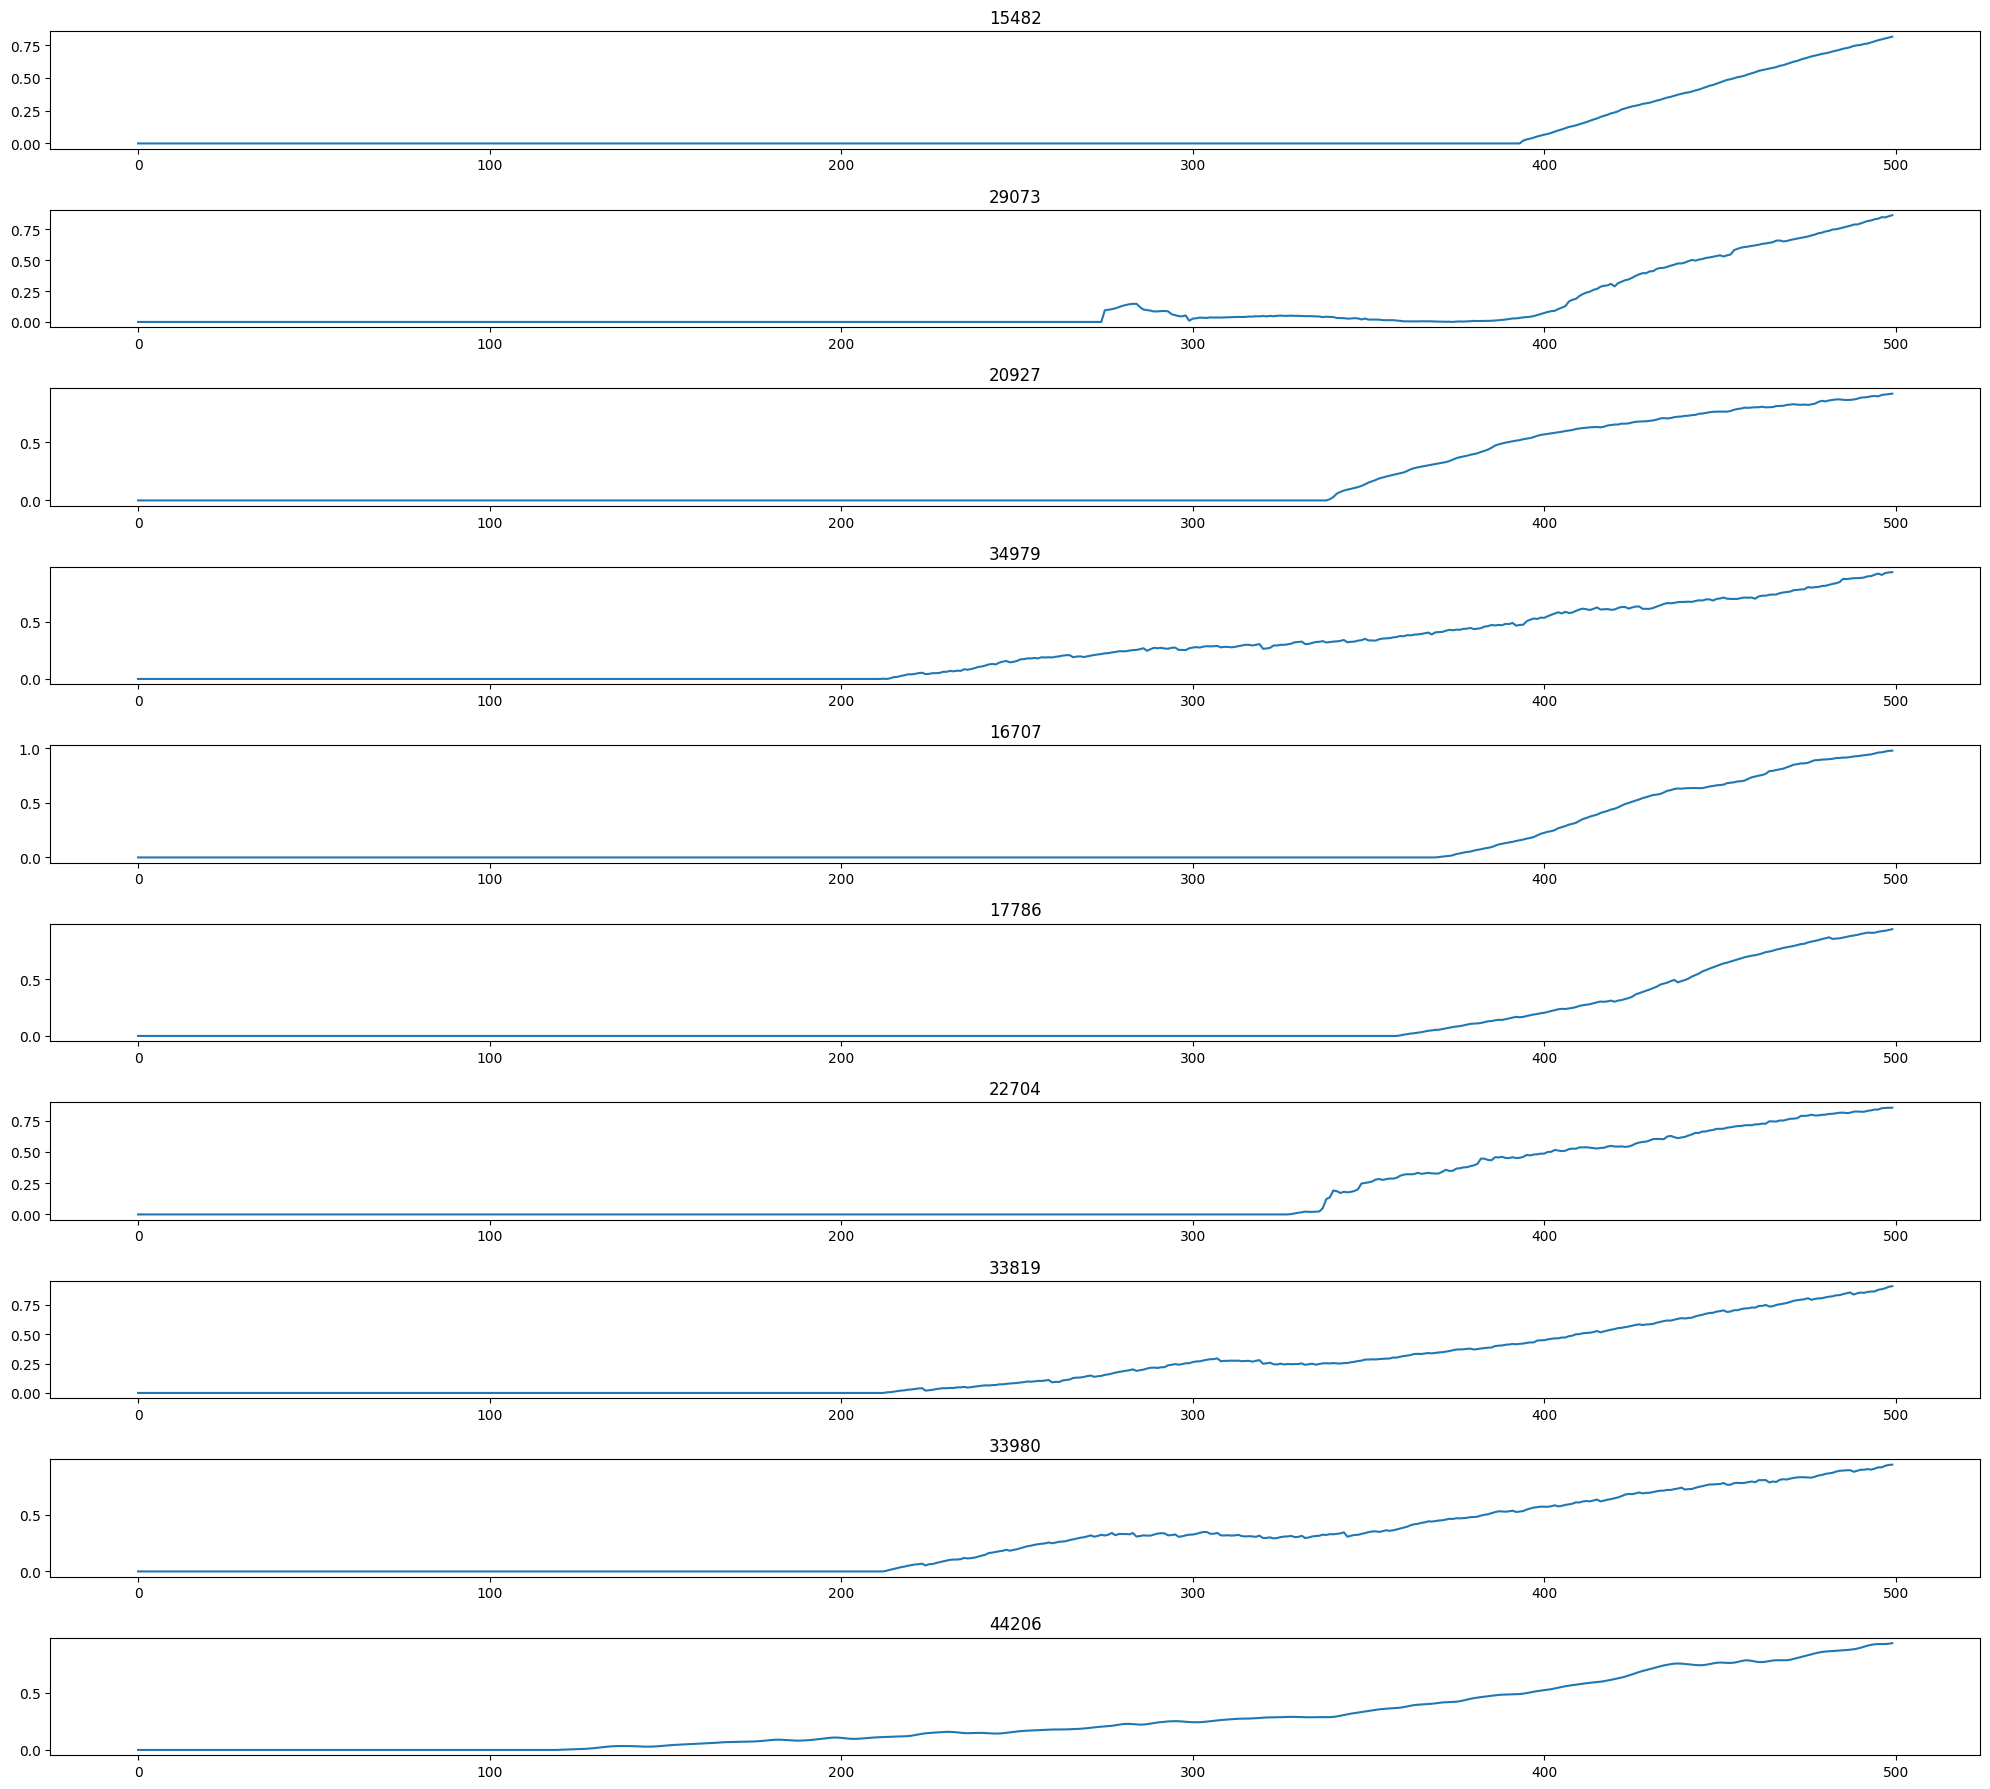

In [32]:
idx = between_075_05_indices_unique_flatten
display_series(unique_series[idx[:display_num], :], categories=idx[:display_num], num_series=display_num, last=500)

# Remove pseudo-duplicates

In [11]:
less_075_indices_unique = np.load("less_075_indices_unique.npy")
less_05_indices_unique  = np.load("less_05_indices_unique.npy")
less_025_indices_unique = np.load("less_025_indices_unique.npy")
less_02_indices_unique = np.load("less_02_indices_unique.npy")
less_015_indices_unique = np.load("less_015_indices_unique.npy")
less_01_indices_unique  = np.load("less_01_indices_unique.npy")

In [12]:
print(len(less_075_indices_unique))
print(len(less_05_indices_unique))
print(len(less_025_indices_unique))
print(len(less_02_indices_unique))
print(len(less_015_indices_unique))
print(len(less_01_indices_unique))

13886
3736
1200
998
803
622


In [13]:
def filter_similar_series(similar_series_indices, time_series_array):
    # Step 1: Identify sets of similar time series using transitive relationship
    similar_series_sets = []
    for indices in similar_series_indices:
        found_sets = []
        for s in similar_series_sets:
            if any(idx in s for idx in indices):
                found_sets.append(s)

        if not found_sets:
            similar_series_sets.append(set(indices))
        else:
            # Merge found sets since they are connected
            new_set = set.union(*found_sets)
            new_set.update(indices)
            similar_series_sets = [s for s in similar_series_sets if s not in found_sets]
            similar_series_sets.append(new_set)

    # Step 2: Keep only one series in each set, and if they have different lengths, keep the longest
    result_series_indices = set(range(time_series_array.shape[0]))
    for series_set in similar_series_sets:
        # Find the longest series in the set
        longest_series_index = max(series_set, key=lambda idx: len(time_series_array[idx]))

        # Remove from the set the shorter series indices
        shorter_series_indices = series_set - {longest_series_index}
        result_series_indices -= shorter_series_indices

    # Convert the set to a list
    result_series_indices_list = list(result_series_indices)

    # Return the indices of the filtered series as a list
    return result_series_indices_list, similar_series_sets


In [14]:
filtered_series_indices_075, similar_set_075 = filter_similar_series(less_075_indices_unique, unique_series)
filtered_series_indices_05, similar_set_05   = filter_similar_series(less_05_indices_unique, unique_series)
filtered_series_indices_025, similar_set_025 = filter_similar_series(less_025_indices_unique, unique_series)
filtered_series_indices_02, similar_set_02   = filter_similar_series(less_02_indices_unique, unique_series)
filtered_series_indices_015, similar_set_015 = filter_similar_series(less_015_indices_unique, unique_series)
filtered_series_indices_01, similar_set_01   = filter_similar_series(less_01_indices_unique, unique_series)

In [15]:
print(len(filtered_series_indices_075))
print(len(filtered_series_indices_05))
print(len(filtered_series_indices_025))
print(len(filtered_series_indices_02))
print(len(filtered_series_indices_015))
print(len(filtered_series_indices_01))

43690
45564
46865
47048
47226
47388


In [38]:
count = 0
for s in similar_set_075:
    if len(s) > 3:
        #print(s)
        count += 1

print(count)

96


In [39]:
count = 0
for s in similar_set_05:
    if len(s) > 3:
        #print(s)
        count += 1

print(count)

52


In [40]:
count = 0
for s in similar_set_025:
    if len(s) > 3:
        print(s)
        count += 1
print()
print(count)

{22808, 22795, 22452, 22443}
{22473, 22469, 22822, 22823}
{41161, 41162, 41163, 41164}
{9976, 9977, 9978, 9979}
{28114, 27530, 25637, 28127}
{20656, 17249, 20657, 17251}
{368, 2130, 2133, 9879}
{16354, 16355, 16356, 16357}
{13312, 13314, 13354, 13356}
{20928, 20929, 20930, 44195, 22564, 22565, 22566, 20920, 46234, 46235, 19163}
{973, 974, 975, 976, 978, 979, 980, 981}

11


In [41]:
count = 0
for s in similar_set_02:
    if len(s) > 3:
        print(s)
        count += 1
print()
print(count)

{41161, 41162, 41163, 41164}
{9976, 9977, 9978, 9979}
{16354, 16355, 16356, 16357}
{13312, 13314, 13354, 13356}
{973, 974, 975, 976, 978, 979, 980, 981}

5


In [42]:
count = 0
for s in similar_set_015:
    if len(s) > 3:
        print(s)
        count += 1
print()
print(count)

{41161, 41162, 41163, 41164}
{9976, 9977, 9978, 9979}
{973, 974, 975, 976, 978, 979, 980, 981}
{16354, 16355, 16356, 16357}

4


In [43]:
count = 0
for s in similar_set_01:
    if len(s) > 3:
        print(s)
        count += 1
print()
print(count)

{9976, 9977, 9978, 9979}
{976, 978, 973, 974, 975}
{16354, 16355, 16356, 16357}

3


Our choice

{41161, 41162, 41163, 41164}


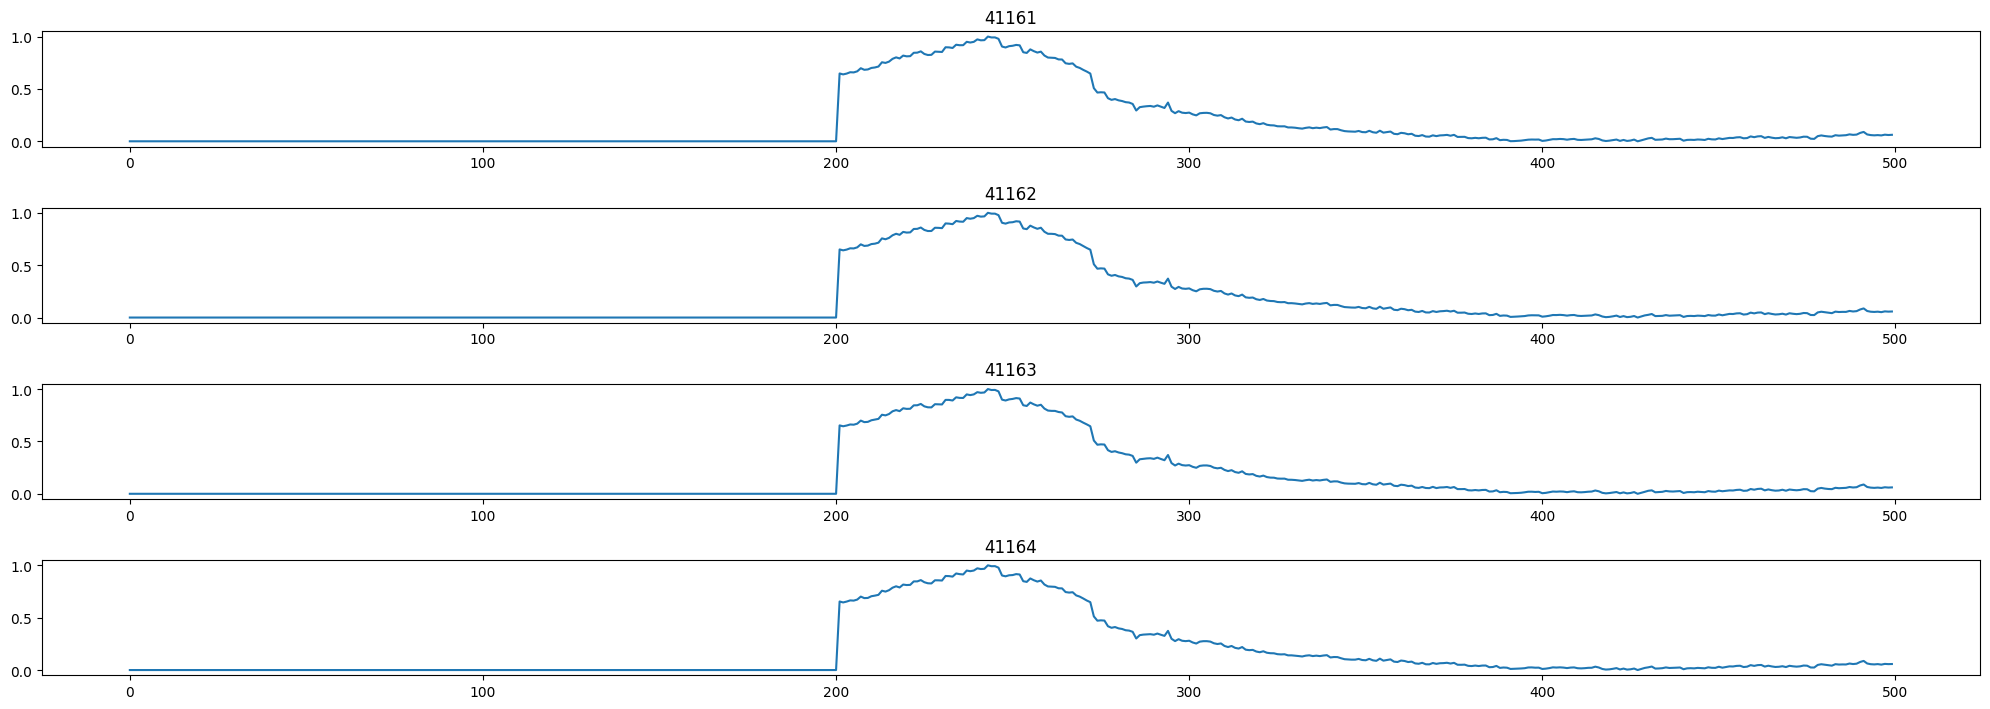

{9976, 9977, 9978, 9979}


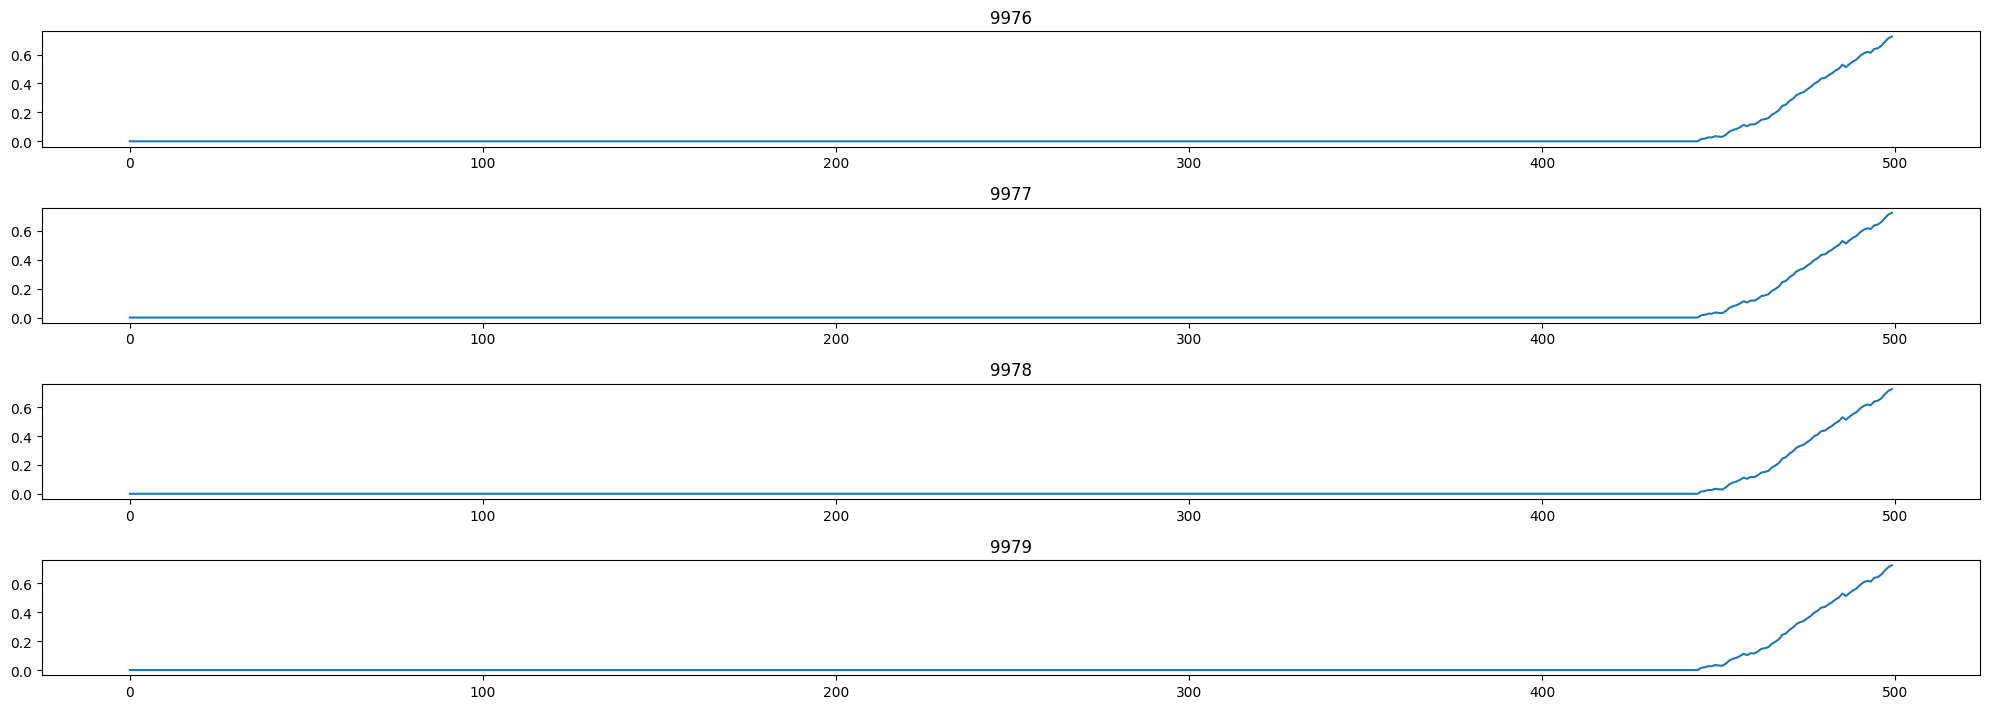

{16354, 16355, 16356, 16357}


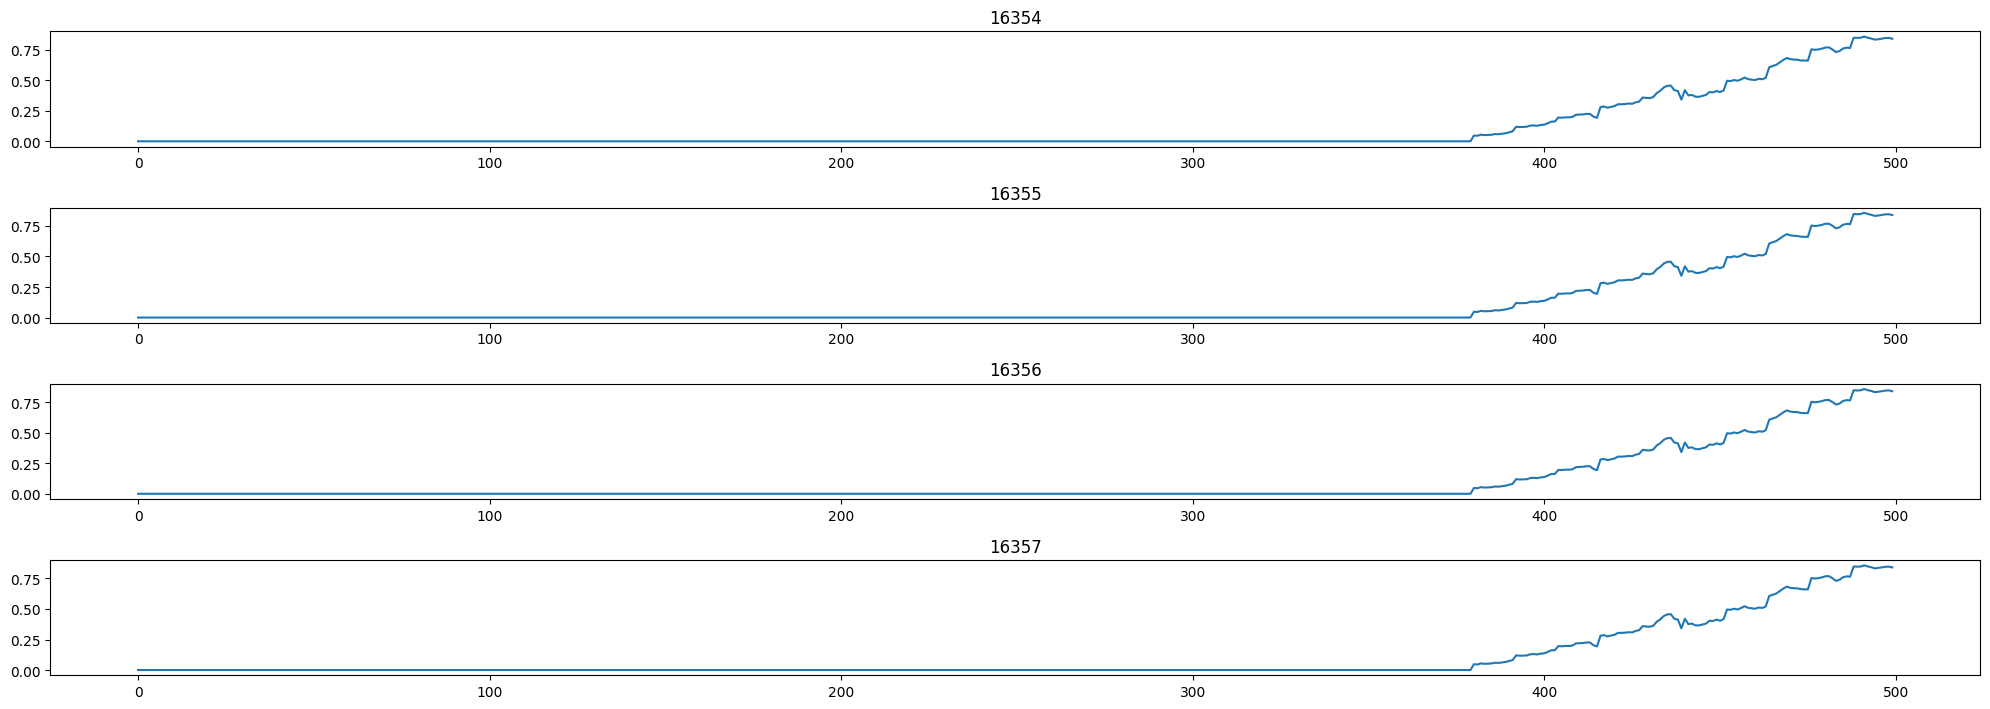

{13312, 13314, 13354, 13356}


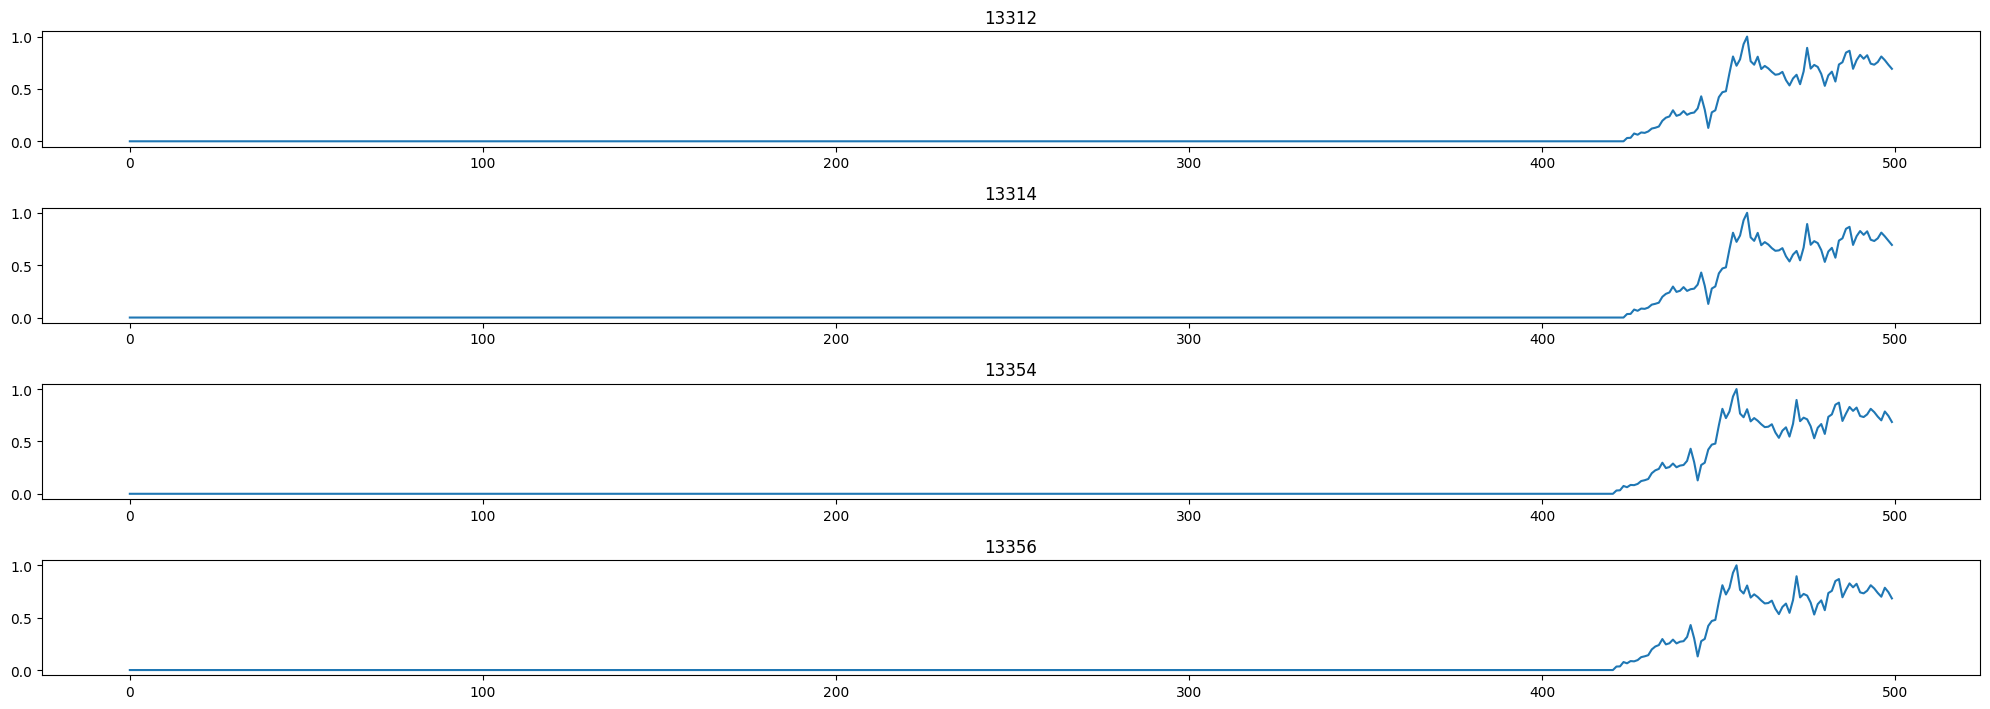

{973, 974, 975, 976, 978, 979, 980, 981}


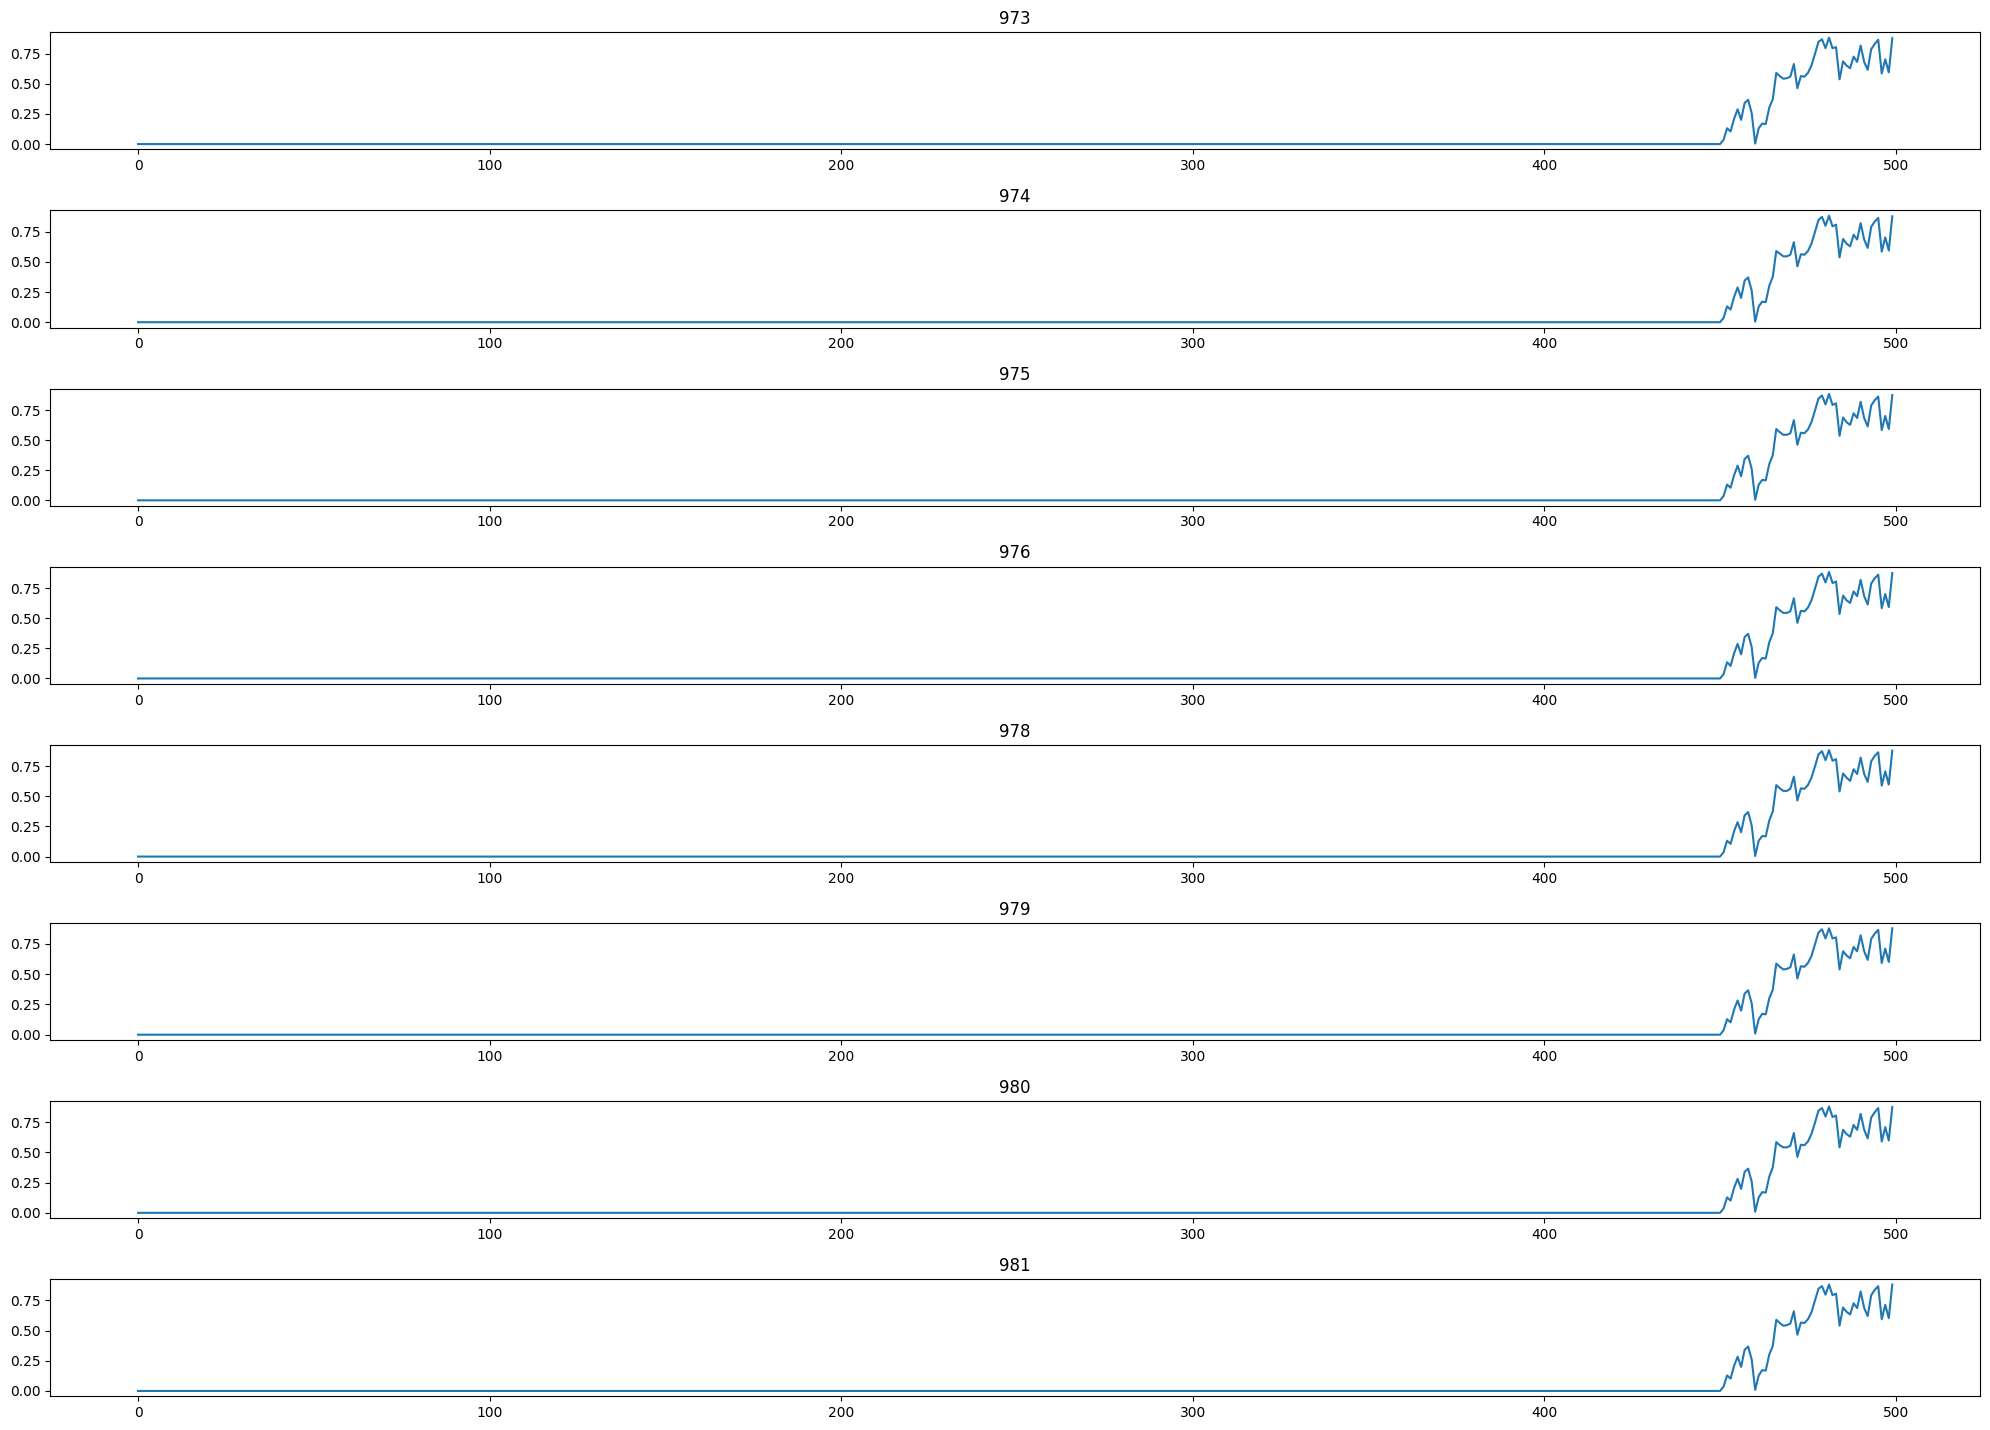

In [44]:
for s in similar_set_02:
    if len(s) > 3:
        print(s)
        idx = list(s)
        display_num = len(idx)
        display_series(unique_series[idx[-display_num:], :], categories=idx[-display_num:], num_series=display_num, last=500)

In [17]:
filtered_series_02 = unique_series[filtered_series_indices_02, :]
filtered_categories_02 = unique_categories[filtered_series_indices_02]
filtered_valid_periods_02 = unique_valid_periods[filtered_series_indices_02]

In [46]:
print(unique_series.shape)
print(unique_categories.shape)
print(unique_valid_periods.shape)

(47974, 2776)
(47974,)
(47974, 2)


In [47]:
print(filtered_series_02.shape)
print(filtered_categories_02.shape)
print(filtered_valid_periods_02.shape)

(47048, 2776)
(47048,)
(47048, 2)


In [18]:
filtered_series_075 = unique_series[filtered_series_indices_075, :]
filtered_categories_075 = unique_categories[filtered_series_indices_075]
filtered_valid_periods_075 = unique_valid_periods[filtered_series_indices_075]

filtered_series_05 = unique_series[filtered_series_indices_05, :]
filtered_categories_05 = unique_categories[filtered_series_indices_05]
filtered_valid_periods_05 = unique_valid_periods[filtered_series_indices_05]

filtered_series_025 = unique_series[filtered_series_indices_025, :]
filtered_categories_025 = unique_categories[filtered_series_indices_025]
filtered_valid_periods_025 = unique_valid_periods[filtered_series_indices_025]

filtered_series_015 = unique_series[filtered_series_indices_015, :]
filtered_categories_015 = unique_categories[filtered_series_indices_015]
filtered_valid_periods_015 = unique_valid_periods[filtered_series_indices_015]

filtered_series_01 = unique_series[filtered_series_indices_01, :]
filtered_categories_01 = unique_categories[filtered_series_indices_01]
filtered_valid_periods_01 = unique_valid_periods[filtered_series_indices_01]

In [19]:
np.save("filtered_series_075.npy", filtered_series_075)
np.save("filtered_categories_075.npy", filtered_categories_075)
np.save("filtered_valid_periods_075.npy", filtered_valid_periods_075)

In [20]:
np.save("filtered_series_05.npy", filtered_series_05)
np.save("filtered_categories_05.npy", filtered_categories_05)
np.save("filtered_valid_periods_05.npy", filtered_valid_periods_05)

In [21]:
np.save("filtered_series_025.npy", filtered_series_025)
np.save("filtered_categories_025.npy", filtered_categories_025)
np.save("filtered_valid_periods_025.npy", filtered_valid_periods_025)

In [22]:
np.save("filtered_series_02.npy", filtered_series_02)
np.save("filtered_categories_02.npy", filtered_categories_02)
np.save("filtered_valid_periods_02.npy", filtered_valid_periods_02)

In [23]:
np.save("filtered_series_015.npy", filtered_series_015)
np.save("filtered_categories_015.npy", filtered_categories_015)
np.save("filtered_valid_periods_015.npy", filtered_valid_periods_015)

In [24]:
np.save("filtered_series_01.npy", filtered_series_01)
np.save("filtered_categories_01.npy", filtered_categories_01)
np.save("filtered_valid_periods_01.npy", filtered_valid_periods_01)